<a href="https://colab.research.google.com/github/btduyforwork/Employee_Attendance/blob/main/Employee_Attendance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install facenet-pytorch faiss-cpu opencv-python-headless matplotlib pillow==9.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 MB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of facenet-pytorch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 13.1 MB/s eta 0:00:00
  Created wheel for pillow: filename=Pillow-9.5.0-cp312-cp312-linux_x86_64.whl size=1210309 sha256=4638bf727b43a3ecf88dafc07e1adc9779b77546fab984b24c7d51eed6d6147f
  Stored in directory: /root/.cache/pip/wheels/ea/de/2e/75a6399e5d8cd3a55c13c8f0658d996d4ce4cff37389de044c
Successfully built pillow
  Attempting uninstall: pillow
    Found existing installation: pillow 11.3.0
    Uninstalling pillow-11.3.0:
      Successfully uninstalled pillow-11.3.0
ERROR: pip's dependency resolver does 

In [1]:
!pip uninstall -y scikit-image

Found existing installation: scikit-image 0.25.2
Uninstalling scikit-image-0.25.2:
  Successfully uninstalled scikit-image-0.25.2


In [49]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import faiss
from facenet_pytorch import InceptionResnetV1
import torch
import torchvision.transforms as T

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import PIL
import io
import html
import time


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Đang dùng:", device)
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

Đang dùng: cuda


In [41]:
# Định nghĩa transform
transform = T.Compose([
    T.Resize((300, 300)),                     # resize ảnh về 300x300
    T.ToTensor(),                             # chuyển PIL image -> tensor [0,1]
    T.Normalize(mean=[0.5, 0.5, 0.5],         # chuẩn hóa về [-1,1]
                 std=[0.5, 0.5, 0.5])
])

In [42]:
def extract_feature(image_path, model):
    # Mở và convert ảnh sang RGB
    img = Image.open(image_path).convert("RGB")
    # Apply transform
    x = transform(img).unsqueeze(0)  # shape (1,3,300,300)
    # Chạy model để lấy embedding
    with torch.no_grad():
        feat = model(x)  # shape (512,)
    return feat.squeeze().numpy().astype("float32")


In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
dataset_dir = "/content/drive/MyDrive/Dataset"  # hoặc đường dẫn trong Drive
image_paths, labels = [], []
for f in os.listdir(dataset_dir):
    if f.lower().endswith((".jpg",".jpeg",".png")):
        path = os.path.join(dataset_dir, f)
        name = f.split("Avatar_")[-1].split(".")[0]
        image_paths.append(path)
        labels.append(name)
print(len(image_paths))
print(image_paths[0])
print(labels[0])

19
/content/drive/MyDrive/Dataset/Avatar_Andrew_Cuomo.jpg
Andrew_Cuomo


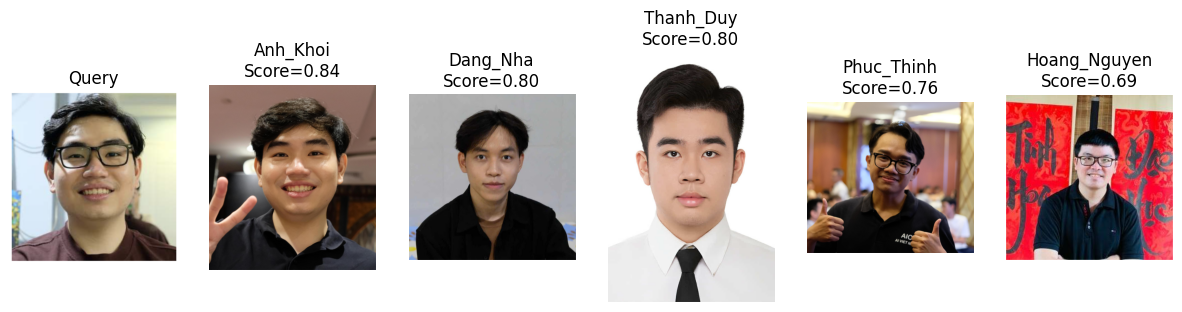

In [64]:
# 2. Transform
transform = T.Compose([
    T.Resize((300,300)),
    T.ToTensor(),
    T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

def extract_feature(image_path, model, device=device):
    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)   # tensor lên GPU
    with torch.no_grad():
        feat = model(x)                          # model chạy trên GPU
    return feat.squeeze().cpu().numpy().astype("float32")

# 3. Build index
dataset_dir = "/content/drive/MyDrive/Dataset"  # hoặc đường dẫn trong Drive
image_paths, labels = [], []
for f in os.listdir(dataset_dir):
    if f.lower().endswith((".jpg",".jpeg",".png")):
        path = os.path.join(dataset_dir, f)
        name = f.split("Avatar_")[-1].split(".")[0]
        image_paths.append(path)
        labels.append(name)

index = faiss.IndexFlatIP(512)
label_map = []
for p,name in zip(image_paths,labels):
    v = extract_feature(p, model)
    index.add(np.array([v]))
    label_map.append(name)

faiss.write_index(index, "facenet_features.index")
np.save("label_map.npy", np.array(label_map))
import matplotlib.pyplot as plt

def search_and_show(query_image_path, k=5):
    index = faiss.read_index("facenet_features.index")
    label_map = np.load("label_map.npy", allow_pickle=True)
    qv = extract_feature(query_image_path, model)
    D,I = index.search(np.array([qv]), k)

    # Hiển thị query
    query_img = Image.open(query_image_path)
    plt.figure(figsize=(15,5))
    plt.subplot(1, k+1, 1)
    plt.imshow(query_img)
    plt.title("Query")
    plt.axis("off")

    # Hiển thị top-k
    for i, idx in enumerate(I[0], start=2):
        img = Image.open(image_paths[idx])
        plt.subplot(1, k+1, i)
        plt.imshow(img)
        plt.title(f"{label_map[idx]}\nScore={D[0][i-2]:.2f}")
        plt.axis("off")
    plt.show()

# Test với 1 ảnh
search_and_show('/content/drive/MyDrive/sample.png', k=5)

In [51]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes


In [52]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [53]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


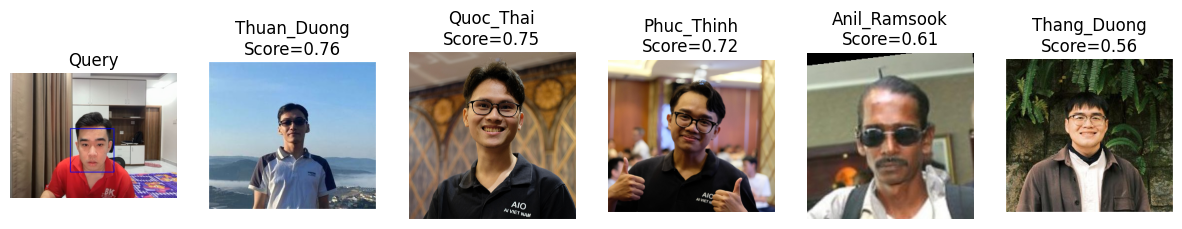

In [66]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  # display(Image(filename))
  search_and_show(filename, k=5)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))